# Predicting Happiness, Migration, and Democracy through Socio-Economic Factors

Here are the links to the five open-source databases I will be using. The first four have direct download links provided, while for the fifth one, you need to click on the download button. Source links for these downloads are listed in the next block. These databases should be downloaded and placed in the correct working directory before running the code.

1. 
https://www.openml.org/data/download/16787568/php8vsf4S

2. 
https://data.un.org/_Docs/SYB/CSV/SYB66_246_202310_Population%20Growth,%20Fertility%20and%20Mortality%20Indicators.csv

3. 
https://data.un.org/_Docs/SYB/CSV/SYB66_230_202310_GDP%20and%20GDP%20Per%20Capita.csv
   
4.
https://api.worldbank.org/v2/en/indicator/SM.POP.NETM?downloadformat=csv

5. https://www.google.com/urlq=https%3A%2F%2Fwww.dropbox.com%2Fscl%2Ffi%2F5zt65z1k958k2n5wusntp%2Fddrevisited_data_v1.xls%3Fdl%3D0%26rlkey%3D4rhdk7qmy8jz31t82v6mnueyy&sa=D&sntz=1&usg=AOvVaw05PP4DthcFHfcy22LxKyLv


Here are the source links

1. 
https://www.openml.org/search?type=data&status=active&id=40916

2.
https://data.un.org/

3.
https://data.un.org/

4.
https://data.worldbank.org/indicator/SM.POP.NETM?end=2015&most_recent_value_desc=false&start=2015

5.
https://sites.google.com/site/joseantoniocheibub/datasets/dd

## Environment Setup

In [1]:
# Importing all the library we will be using
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold,LeaveOneOut,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.linear_model import Ridge, Lasso
import statsmodels.api as sm
from sklearn.cluster import KMeans
import itertools
import argparse
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization 
from keras.optimizers import RMSprop
import random

In [2]:
# Set seeds for reproducibility
def set_seeds(seed=9):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
# Call the function to set seeds
set_seeds(9)

In [3]:
import os
# Set the working directory
os.chdir('C:\\Users\\gavha\\Downloads')

## Data loading

Loading the Happiness database

In [4]:
# Load the ARFF (Happiness) file
data, meta = arff.loadarff('php8vsf4S.arff')

# Convert to a pandas DataFrame
Happiness = pd.DataFrame(data)[['Country', 'Region', 'Happiness Score']]

# Decode byte strings to regular strings in the 'Country' and 'Region' columns
Happiness[['Country', 'Region']] = Happiness[['Country', 'Region']].applymap(lambda x: x.decode('utf-8'))

# Define the countries not recognised by the un to be removed
countries_to_remove = ['Taiwan', 'North Cyprus', 'Palestinian Territories']

# Filter Happiness DataFrame to exclude rows where 'Country' column is in countries_to_remove
Happiness = Happiness[~Happiness['Country'].isin(countries_to_remove)]

# Print the first few rows of the DataFrame
print(Happiness.head())

       Country          Region  Happiness Score
0  Switzerland  Western Europe            7.587
1      Iceland  Western Europe            7.561
2      Denmark  Western Europe            7.527
3       Norway  Western Europe            7.522
4       Canada   North America            7.427


Loading the Economic and Population databases 

In [5]:
# Define file paths for CSV files
file_paths = [
    'SYB66_246_202310_Population Growth, Fertility and Mortality Indicators.csv',
    'SYB66_230_202310_GDP and GDP Per Capita.csv',
]

# Read each CSV file into a DataFrame and rename the first column to 'Country'
dataframes = [pd.read_csv(file, encoding='latin1').rename(columns={pd.read_csv(file, encoding='latin1').columns[1]: 'Country'}) for file in file_paths]

# Print the first few rows of each DataFrame to verify changes
for df in dataframes:
    print(df.head())

# Concatenate all DataFrames into a single DataFrame
Stats = pd.concat(dataframes, ignore_index=True)

# Filter Stats to include only rows where 'Unnamed: 2' column is '2015' and only relevant columns
Stats_2015 = Stats[Stats['Unnamed: 2'] == '2015'][['Country', 'Unnamed: 3', 'Unnamed: 4']]

                   T03                        Country Unnamed: 2  \
0  Region/Country/Area                            NaN       Year   
1                    1  Total, all countries or areas       2010   
2                    1  Total, all countries or areas       2010   
3                    1  Total, all countries or areas       2010   
4                    1  Total, all countries or areas       2010   

                                          Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0                                             Series      Value  Footnotes   
1       Population annual rate of increase (percent)        1.3        NaN   
2          Total fertility rate (children per women)        2.6        NaN   
3  Infant mortality for both sexes (per 1,000 liv...       37.1        NaN   
4  Maternal mortality ratio (deaths per 100,000 p...        254        NaN   

                                          Unnamed: 6  
0                                             Source  
1  United Na

Preping the economic and populaition database for merging
Standardising the country names in the economic and populaition database and pivoting it to be in a suitable format.

In [6]:
# Dictionary for replacing country names
replacements = {
    'Netherlands (Kingdom of the)': 'Netherlands',
    'United States of America': 'United States',
    'Venezuela (Boliv. Rep. of)': 'Venezuela',
    'Czechia': 'Czech Republic',
    'Republic of Korea': 'South Korea',
    'Bolivia (Plurin. State of)': 'Bolivia',
    'Republic of Moldova': 'Moldova',
    'Russian Federation': 'Russia',
    'China, Hong Kong SAR': 'Hong Kong',
    'Viet Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Somalia': 'Somaliland region',
    'North Macedonia': 'Macedonia',
    "Lao People's Dem. Rep.": 'Laos',
    'Eswatini': 'Swaziland',
    'Iran (Islamic Republic of)': 'Iran',
    'Dem. Rep. of the Congo': 'Congo (Kinshasa)',
    'Congo': 'Congo (Brazzaville)',
    'United Rep. of Tanzania': 'Tanzania',
    "Côte d\x92Ivoire": 'Ivory Coast',
    'Syrian Arab Republic': 'Syria',
    'Congo (Brazzaville, Republic of Congo)': 'Congo (Brazzaville)',
    'Venezuela, RB': 'Venezuela',
    'Korea, Rep.': 'South Korea',
    'Turkiye': 'Turkey',
    "Lao PDR": 'Laos',
    'Iran, Islamic Rep.': 'Iran',
    'Democratic Republic of the Congo (Zaire, Congo-Kinshasha)': 'Congo (Kinshasa)',
    'Congo, Rep.': 'Congo (Brazzaville)',
    "Cote d'Ivoire": 'Ivory Coast',
    'Slovak Republic': 'Slovakia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    "Egypt, Arab Rep.": 'Egypt',
    'Yemen, Rep.': 'Yemen',
    'Libyan Arab Jamahiriya': 'Libya',
    'Congo, Dem. Rep.': 'Congo (Kinshasa)'
}

# Replace country names in the 'Country' column of Stats_2015 using the replacements dictionary
Stats_2015['Country'] = Stats_2015['Country'].replace(replacements)

# Filter Stats_2015 to include only countries present in Happiness DataFrame
Stats_2015 = Stats_2015[Stats_2015['Country'].isin(Happiness['Country'])]

# Pivot the DataFrame to create a new structure
Stats_2015_Pivoted = Stats_2015.pivot_table(index='Country', columns='Unnamed: 3', values='Unnamed: 4', aggfunc='first')
Stats_2015_Pivoted.reset_index(inplace=True)
Stats_2015_Pivoted.columns.name = None

Merging the database and filtering out entries with missing values

In [7]:
# Merge Happiness DataFrame and Stats_2015_Pivoted DataFrame on 'Country' as index
Happiness_Stats = pd.concat([Happiness.set_index('Country'), Stats_2015_Pivoted.set_index('Country')], axis=1)
Happiness_Stats.reset_index(inplace=True)

# Calculate the count of missing values in each row
na_counts_rows = Happiness_Stats.isna().sum(axis=1)

# Create and print a DataFrame to show the countries and their NA counts
na_countries = pd.DataFrame({
    'Country': Happiness_Stats['Country'][na_counts_rows >= 1],
    'NA Counts': na_counts_rows[na_counts_rows >= 1]
})
print("Countries with missing values:")
print(na_countries)

# Filter out rows with any missing values
Happiness_Stats_Filtered = Happiness_Stats[na_counts_rows == 0]

# Print the shapes of the original and filtered DataFrames
print("Shape of unfiltered DataFrame:", Happiness_Stats.shape)
print("Shape of filtered DataFrame:", Happiness_Stats_Filtered.shape)

# Print or further process Happiness_Stats DataFrame as needed
print(Happiness_Stats)

Countries with missing values:
      Country  NA Counts
66     Kosovo          7
69  Hong Kong          1
Shape of unfiltered DataFrame: (155, 14)
Shape of filtered DataFrame: (153, 14)
         Country                           Region  Happiness Score  \
0    Switzerland                   Western Europe            7.587   
1        Iceland                   Western Europe            7.561   
2        Denmark                   Western Europe            7.527   
3         Norway                   Western Europe            7.522   
4         Canada                    North America            7.427   
..           ...                              ...              ...   
150       Rwanda               Sub-Saharan Africa            3.465   
151        Benin               Sub-Saharan Africa            3.340   
152        Syria  Middle East and Northern Africa            3.006   
153      Burundi               Sub-Saharan Africa            2.905   
154         Togo               Sub-Saharan A

## Regression Analysis

Removing unintresting and highly correlated columns and making sure everything is numeric and renaming long columns

In [8]:
# Remove unintresting columns
columns_to_drop = ['GDP in constant 2015 prices (millions of US dollars)',
                   'GDP in current prices (millions of US dollars)']
Happiness_Stats_Filtered.drop(columns_to_drop, axis=1, inplace=True)

# Drop highly correlated columns
columns_to_drop = ['Life expectancy at birth for females (years)',
                   'Life expectancy at birth for males (years)',
                   'Infant mortality for both sexes (per 1,000 live births)']
Happiness_Stats_Filtered.drop(columns_to_drop, axis=1, inplace=True)

# Remove commas from numeric columns and convert to numeric
Happiness_Stats_Filtered = Happiness_Stats_Filtered.replace(',', '', regex=True)
for col in Happiness_Stats_Filtered.columns:
    if col not in ['Country', 'Region']:
        Happiness_Stats_Filtered[col] = pd.to_numeric(Happiness_Stats_Filtered[col], errors='coerce')
# Define a mapping dictionary for new column names
new_names = {
    'Country': 'Country',
    'Region': 'Region',
    'Happiness Score': 'Happiness',
    'GDP per capita (US dollars)': 'GDP per capita',
    'GDP real rates of growth (percent)': 'GDP growth',
    'Life expectancy at birth for both sexes (years)': 'Life expectancy',
    'Maternal mortality ratio (deaths per 100,000 population)': 'Maternal mortality',
    'Population annual rate of increase (percent)': 'Population growth',
    'Total fertility rate (children per women)': 'Fertility rate'
}

# Rename columns using the mapping dictionary
Happiness_Stats_Filtered = Happiness_Stats_Filtered.rename(columns=new_names)

C:\Users\gavha\AppData\Local\Temp\ipykernel_31680\946410773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Happiness_Stats_Filtered.drop(columns_to_drop, axis=1, inplace=True)
C:\Users\gavha\AppData\Local\Temp\ipykernel_31680\946410773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Happiness_Stats_Filtered.drop(columns_to_drop, axis=1, inplace=True)


Getting some summary statistics for our data and plotting our data

In [9]:
print(Happiness_Stats_Filtered.describe())

        Happiness  GDP per capita  GDP growth  Life expectancy  \
count  153.000000      153.000000  153.000000       153.000000   
mean     5.369902    13469.385621    3.043137        71.666013   
std      1.159586    18820.857635    5.246863         8.269205   
min      2.839000      262.000000  -36.100000        51.100000   
25%      4.517000     1563.000000    1.800000        65.100000   
50%      5.194000     5274.000000    3.200000        73.300000   
75%      6.269000    16775.000000    5.000000        77.700000   
max      7.587000   105456.000000   24.400000        83.900000   

       Maternal mortality  Population growth  Fertility rate  
count           153.00000         153.000000      153.000000  
mean            157.30719           1.418954        2.797386  
std             227.65545           1.546760        1.440940  
min               1.00000          -3.000000        1.200000  
25%               8.00000           0.500000        1.700000  
50%              44.00000  

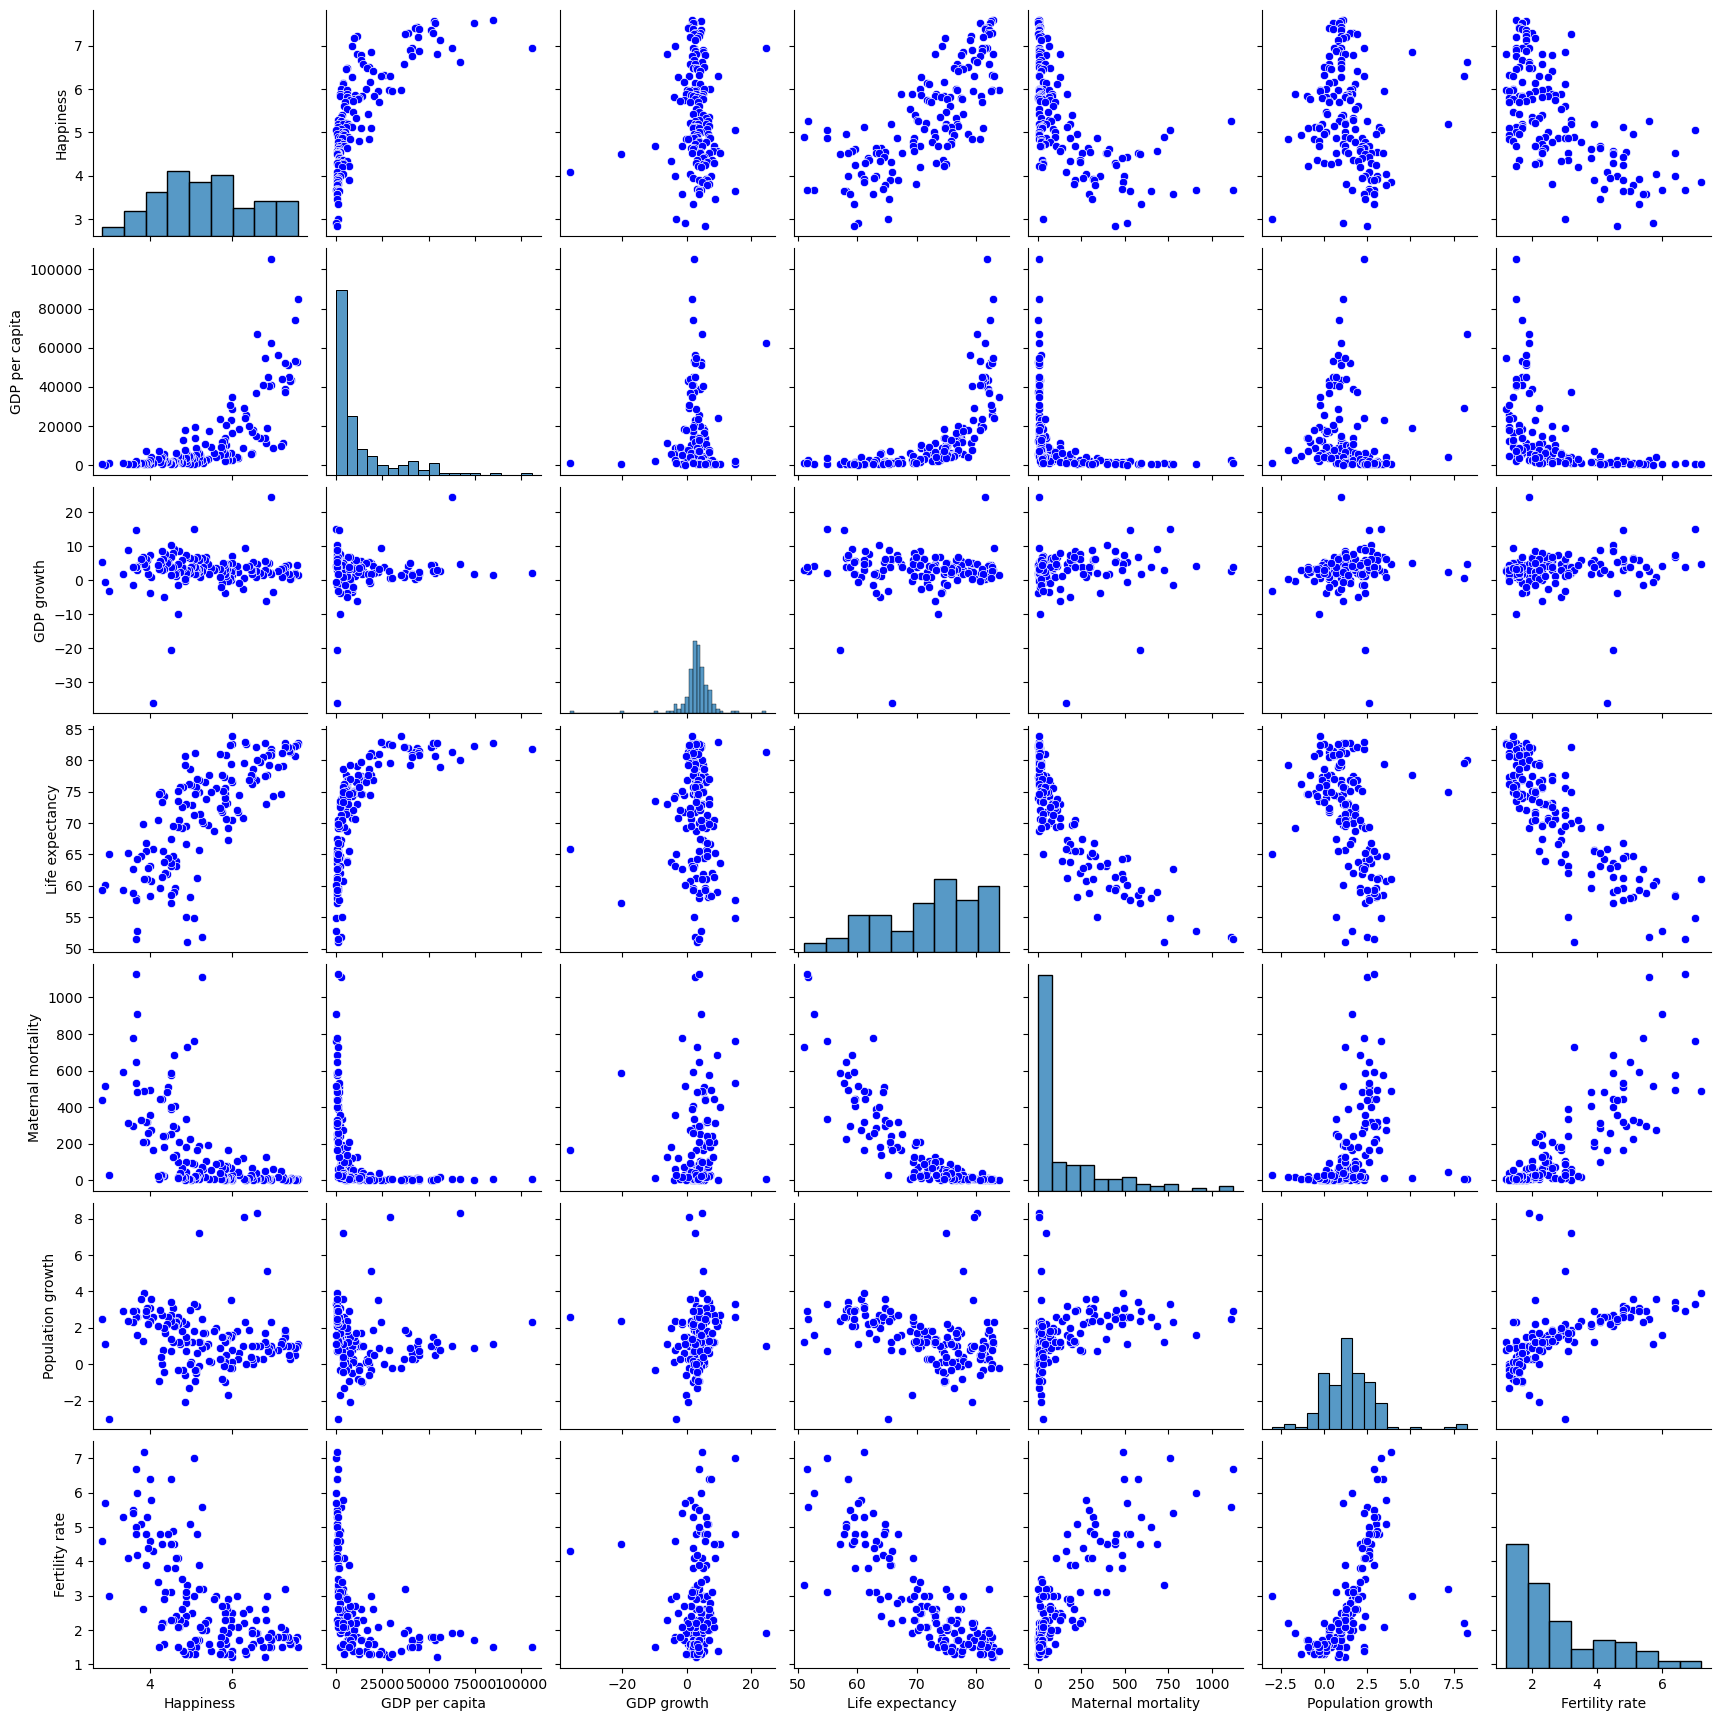

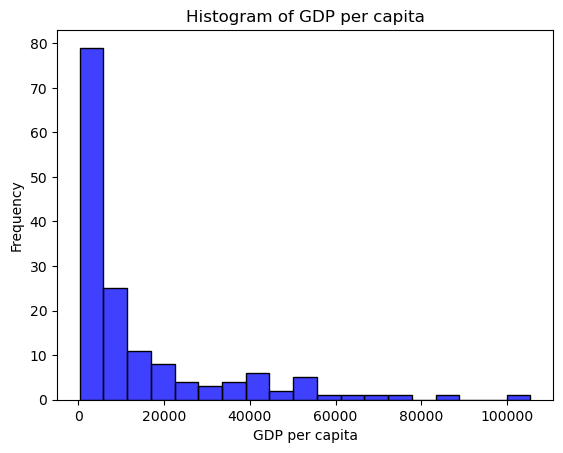

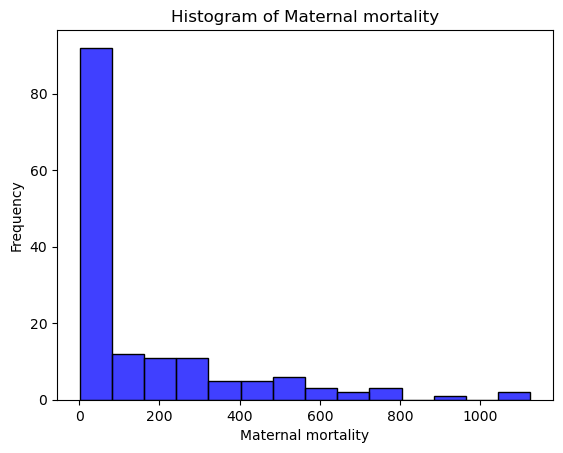

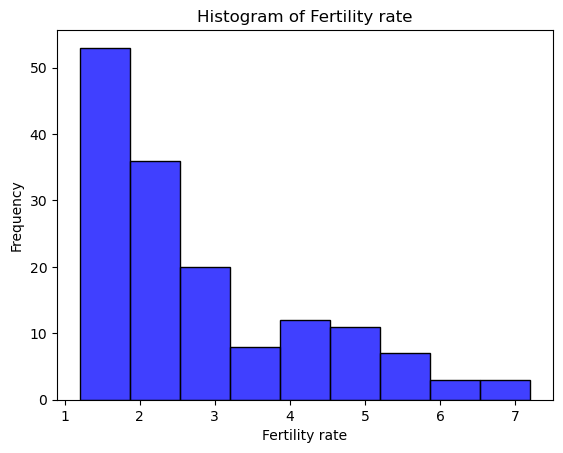

In [10]:
# Plotting all our variables
sns.pairplot(Happiness_Stats_Filtered, plot_kws={'color': 'blue'})  # Use your desired color here
# Display the plot
plt.show()
# Plotting the right skwewed variables
for column in Happiness_Stats_Filtered[['GDP per capita', 
    'Maternal mortality',
    'Fertility rate']].columns:
    plt.figure()  # Create a new figure for each histogram
    sns.histplot(Happiness_Stats_Filtered[column], color='blue', kde=False)  # Plot histogram
    plt.title(f'Histogram of {column}')  # Set title of the histogram
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label
    plt.show()  # Display the histogram

Logging right skewed columns

In [11]:
# logging right skewed columns
Happiness_Stats_Filtered[['GDP per capita','Maternal mortality',
'Fertility rate']] = Happiness_Stats_Filtered[['GDP per capita', 
'Maternal mortality','Fertility rate']].apply(lambda x: np.log(x))

Creating our correlation matrix

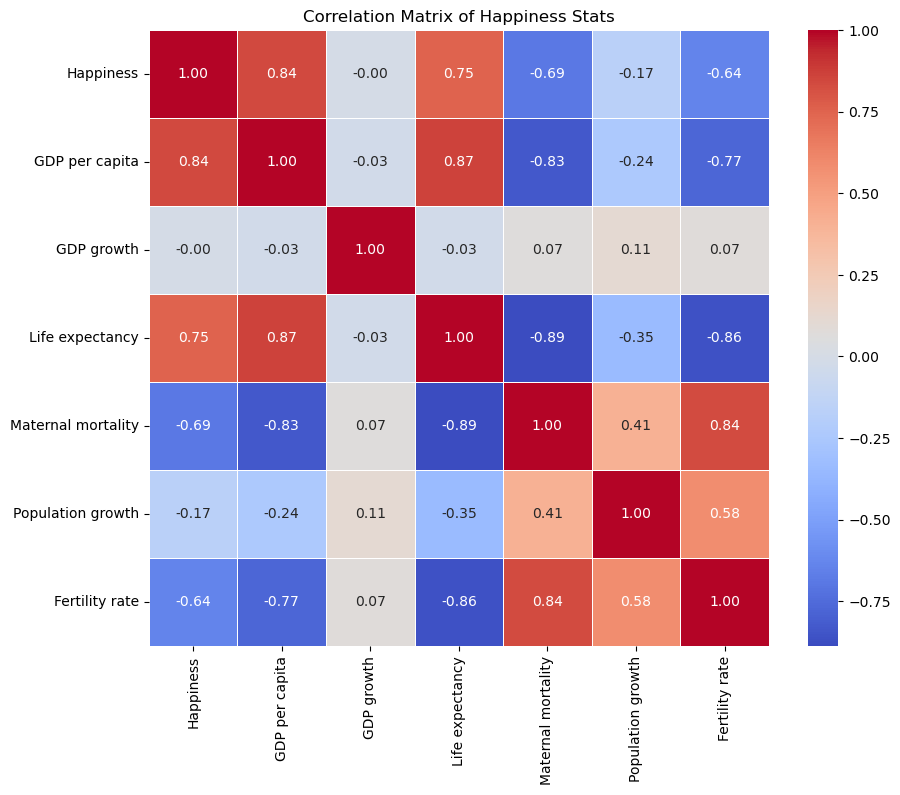

In [12]:
# Recalculate the correlation matrix after dropping columns
correlation_matrix = Happiness_Stats_Filtered.drop(['Country', 'Region'], axis=1).corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Happiness Stats')
plt.show()

Basic linear regression model

In [13]:
X = Happiness_Stats_Filtered.drop(['Country', 'Region', 'Happiness'], axis=1)
y = Happiness_Stats_Filtered['Happiness']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Function to fit the model and return the model object
def fit_model(X, y):
    model = sm.OLS(y, X).fit()
    return model

# Fit the model on training data
model = fit_model(X_train, y_train)

# Print the summary of the model
print(model.summary())

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = round(mean_squared_error(y_test, y_pred),3)
r2 = round(r2_score(y_test, y_pred),3)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"R-squared on Test Set: {r2}")

                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     48.98
Date:                Mon, 22 Jul 2024   Prob (F-statistic):           1.91e-29
Time:                        14:09:01   Log-Likelihood:                -115.01
No. Observations:                 122   AIC:                             244.0
Df Residuals:                     115   BIC:                             263.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8457      1

Calculating the average MSE when we use 153 folds, i.e., leave-one-out cross-validation.

In [14]:
# Initialize leave-one-out cross-validation
loo = LeaveOneOut()

# List to store MSE for each fold
mse_scores = []

# Perform leave-one-out cross-validation
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on training data
    model = fit_model(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    
    # Append the MSE to the list
    mse_scores.append(mse)

# Calculate average MSE across all folds
avg_mse = np.mean(mse_scores)

print(f"Average MSE for 153 folds ('leave one out'): {avg_mse:.3f}")

Average MSE for 153 folds ('leave one out'): 0.423


Analysing our linear regression

C:\Users\gavha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


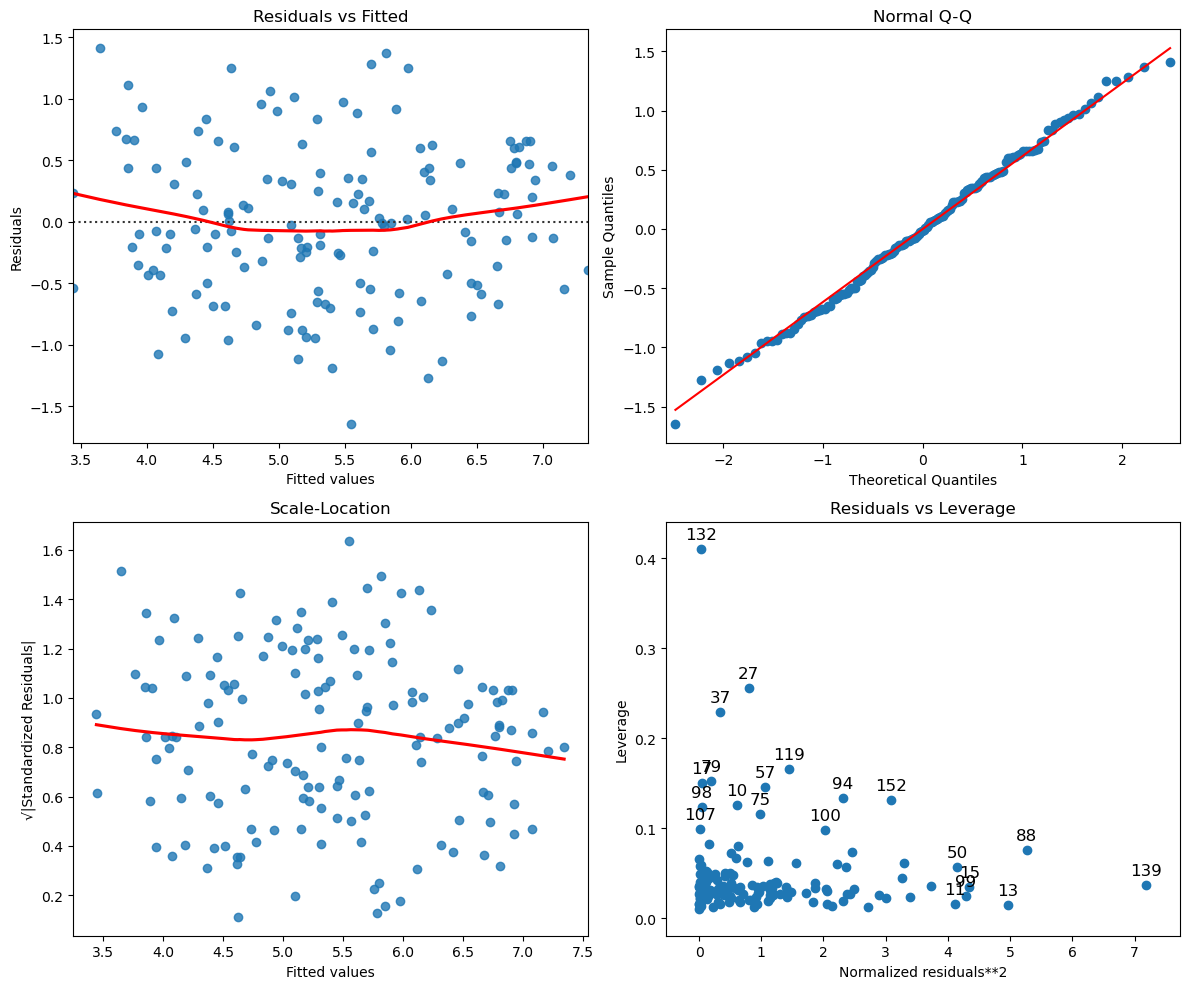

In [15]:
# Get residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

# Diagnostic Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residual vs Fitted Plot
sns.residplot(fitted_values, residuals, lowess=True, ax=axes[0, 0], line_kws={'color': 'red'})
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].set_xlabel('Fitted values')
axes[0, 0].set_ylabel('Residuals')

# QQ Plot of Residuals
sm.qqplot(residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q')

# Scale-Location Plot
sqrt_standardized_residuals = np.sqrt(np.abs(residuals / np.std(residuals)))
sns.regplot(fitted_values, sqrt_standardized_residuals, lowess=True, ax=axes[1, 0], line_kws={'color': 'red'})
axes[1, 0].set_title('Scale-Location')
axes[1, 0].set_xlabel('Fitted values')
axes[1, 0].set_ylabel('√|Standardized Residuals|')

# Residuals vs Leverage Plot
sm.graphics.plot_leverage_resid2(model, ax=axes[1, 1])
axes[1, 1].set_title('Residuals vs Leverage')

# Adjust layout
plt.tight_layout()
plt.show()

Linear regression model using BIC

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Perform best subset selection based on BIC
def best_subset_selection(x, y):
    results = []
    # Iterate over all possible combinations of predictors
    for k in range(1, len(x.columns) + 1):
        for combo in itertools.combinations(x.columns, k):
            X = x[list(combo)]  # Subset of predictors
            model = fit_model(X, y)  # Fit OLS model
            bic = model.bic  # Calculate BIC
            results.append((bic, combo))  # Store BIC and predictor combination
    return results

# Perform best subset selection on training data
train_results = best_subset_selection(X_train, y_train)

# Find the best model based on BIC for training data
best_train_model = min(train_results, key=lambda item: item[0])
print("Best model with predictors (BIC) on training data:", best_train_model[1])
print("BIC on training data:", best_train_model[0])

# Fit the best model based on BIC on training data
X_train_best = X_train[list(best_train_model[1])]  # Select predictors of the best model
best_train_model_fit = fit_model(X_train_best, y_train)  # Fit the best model

# Print the summary of the best model based on BIC on training data
print(best_train_model_fit.summary())

# Evaluate the model on test data
X_test_best = X_test[list(best_train_model[1])]  # Select predictors of the best model for test data
y_test_pred = best_train_model_fit.predict(X_test_best)

# Calculate performance metrics
mse_test = round(mean_squared_error(y_test, y_test_pred),3)
r2_test = round(r2_score(y_test, y_test_pred),3)

print(f"Mean Squared Error on Test Set: {mse_test}")
print(f"R-squared on Test Set: {r2_test}")

Best model with predictors (BIC) on training data: ('GDP per capita',)
BIC on training data: 241.76163360756323
                                 OLS Regression Results                                
Dep. Variable:              Happiness   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              8584.
Date:                Mon, 22 Jul 2024   Prob (F-statistic):                   3.27e-114
Time:                        14:09:02   Log-Likelihood:                         -118.48
No. Observations:                 122   AIC:                                      239.0
Df Residuals:                     121   BIC:                                      241.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
        

Calculating the average MSE when we use 10 fold cross validation

In [17]:
# Function to fit OLS model
def fit_model(X, y):
    X = sm.add_constant(X)  # Adds a constant term to the predictor matrix
    model = sm.OLS(y, X).fit()
    return model

# Function to perform best subset selection based on BIC
def best_subset_selection(x, y):
    results = []
    # Iterate over all possible combinations of predictors
    for k in range(1, len(x.columns) + 1):
        for combo in itertools.combinations(x.columns, k):
            X = x[list(combo)]  # Subset of predictors
            model = fit_model(X, y)  # Fit OLS model
            bic = model.bic  # Calculate BIC
            results.append((bic, combo))  # Store BIC and predictor combination
    return results

# Function to perform 10-fold cross-validation for best subset selection based on BIC
def cross_validation_best_subset(x, y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=9)
    mse_scores = []

    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Perform best subset selection on training data
        train_results = best_subset_selection(X_train, y_train)

        # Find the best model based on BIC for training data
        best_train_model = min(train_results, key=lambda item: item[0])
        X_train_best = X_train[list(best_train_model[1])]  # Select predictors of the best model
        best_train_model_fit = fit_model(X_train_best, y_train)  # Fit the best model

        # Evaluate the model on test data
        X_test_best = sm.add_constant(X_test[list(best_train_model[1])])  # Add constant to test predictors
        y_test_pred = best_train_model_fit.predict(X_test_best)

        # Calculate MSE and store
        mse_test = mean_squared_error(y_test, y_test_pred)
        mse_scores.append(mse_test)

    avg_mse = np.mean(mse_scores)
    return avg_mse

# Perform 10-fold cross-validation for MSE
avg_mse = cross_validation_best_subset(X, y, n_splits=10)

print(f"Average MSE for 10 fold CV: {round(avg_mse,3)}")

Average MSE for 10 fold CV: 0.407


Ridge regression

In [18]:
X = Happiness_Stats_Filtered.drop(['Country', 'Region', 'Happiness'], axis=1)
y = Happiness_Stats_Filtered['Happiness']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=9)

# Fit the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # You can tune the alpha parameter
ridge_model.fit(X_train, y_train)

# Predict and calculate mean squared error
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = round(mean_squared_error(y_test, y_pred_ridge),3)
print("Ridge Regression Mean Squared Error:", mse_ridge)

# Print coefficients with feature names
ridge_coefficients = pd.DataFrame({
    'Feature': ['const'] + X.columns.tolist(),
    'Coefficient': [ridge_model.intercept_] + ridge_model.coef_.tolist()
})
print("Ridge Regression Coefficients:")
print(ridge_coefficients)

Ridge Regression Mean Squared Error: 0.418
Ridge Regression Coefficients:
              Feature  Coefficient
0               const     5.395777
1      GDP per capita     0.836430
2          GDP growth     0.003924
3     Life expectancy     0.224143
4  Maternal mortality     0.065755
5   Population growth     0.127894
6      Fertility rate    -0.055141


Lasso regression

In [19]:
# Fit the Lasso regression model
lasso_model = Lasso(alpha=0.1)  # You can tune the alpha parameter
lasso_model.fit(X_train, y_train)

# Predict and calculate mean squared error
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = round(mean_squared_error(y_test, y_pred_lasso),3)
print("\nLasso Regression Mean Squared Error:", mse_lasso)

# Print coefficients with feature names
lasso_coefficients = pd.DataFrame({
    'Feature': ['const'] + X.columns.tolist(),
    'Coefficient': [lasso_model.intercept_] + lasso_model.coef_.tolist()
})
print("Lasso Regression Coefficients:")
print(lasso_coefficients)


Lasso Regression Mean Squared Error: 0.371
Lasso Regression Coefficients:
              Feature  Coefficient
0               const     5.382202
1      GDP per capita     0.809693
2          GDP growth     0.000000
3     Life expectancy     0.091374
4  Maternal mortality    -0.000000
5   Population growth     0.000000
6      Fertility rate    -0.000000


Calculating the average MSE when we use 10 fold cross validation for Ridge and Lasso regression

In [20]:
X = Happiness_Stats_Filtered.drop(['Country', 'Region', 'Happiness'], axis=1)
y = Happiness_Stats_Filtered['Happiness']

# Define the models
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

# Define the cross-validation strategy (10-fold CV)
kf = KFold(n_splits=10, shuffle=True, random_state=9)

# Perform cross-validation for Ridge
ridge_scores = cross_val_score(ridge_model, X_scaled, y, scoring='neg_mean_squared_error', cv=kf)
ridge_mse_cv = -ridge_scores.mean()
print("Ridge Regression 10-fold CV MSE:", round(ridge_mse_cv, 3))

# Perform cross-validation for Lasso
lasso_scores = cross_val_score(lasso_model, X_scaled, y, scoring='neg_mean_squared_error', cv=kf)
lasso_mse_cv = -lasso_scores.mean()
print("Lasso Regression 10-fold CV MSE:", round(lasso_mse_cv, 3))

Ridge Regression 10-fold CV MSE: 0.436
Lasso Regression 10-fold CV MSE: 0.421


Using random forests to predict happpiness based on all our variables

Mean Squared Error (Random Forest - 10-fold CV): 0.35 (± 0.12)


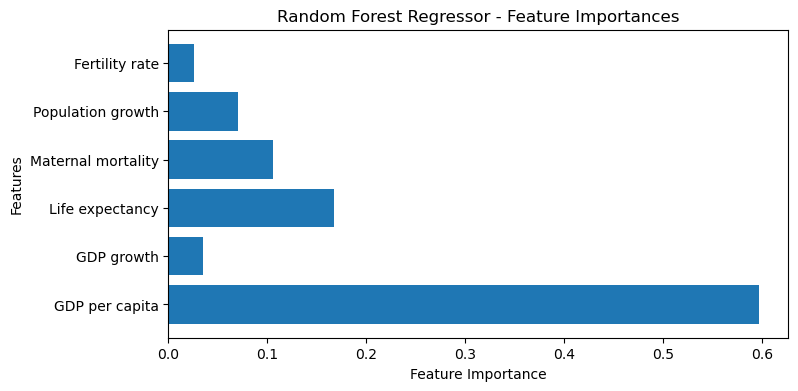

In [21]:
# Define your target variable and features
target_variable = 'Happiness'
features = Happiness_Stats_Filtered.drop(['Country', 'Region', target_variable], axis=1)
target = Happiness_Stats_Filtered[target_variable]

# Initialize the Random Forest Regressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=9)

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=9)
mse_scores = cross_val_score(forest_reg, features, target, scoring='neg_mean_squared_error', cv=kf)
mse_scores = -mse_scores  # Convert scores to positive MSE

# Print the average MSE across all folds
print(f"Mean Squared Error (Random Forest - 10-fold CV): {mse_scores.mean():.2f} (± {mse_scores.std():.2f})")

# Optional: Visualize feature importances
forest_reg.fit(features, target)  # Fit on entire dataset for feature importances
feature_importances = forest_reg.feature_importances_

plt.figure(figsize=(8, 4))
plt.barh(features.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor - Feature Importances')
plt.show()

## Loading Migration database

Loading the migraition database and turning the migraition column into a binary variable

In [22]:
Migration = pd.read_csv('API_SM.POP.NETM_DS2_en_csv_v2_396744.csv',skiprows=3) 
Migration.head()
Migration['Net positive migration'] = Migration['2015'].apply(lambda x: 1 if x > 0 else 0)
Migration=Migration[['Country Name','Net positive migration']]
# Display the modified DataFrame to verify
Migration.head()
# Replace the country names in the 'Country' column of Stats_2015
Migration['Country Name'] = Migration['Country Name'].replace(replacements)

Merging the migraition column onto our old happiness databse and naming it Migration_stats

In [23]:
# Perform left merge with Happiness_Stats_Filtered
Migration_stats = Happiness_Stats_Filtered.merge(Migration,
                                                left_on='Country',
                                                right_on='Country Name',
                                                how='left')

# Drop the duplicate 'Country Name' column 
if 'Country Name' in Migration_stats.columns:
    Migration_stats.drop('Country Name', axis=1, inplace=True)

# Display the merged DataFrame
print("\nMerged DataFrame (Happiness_Stats_Filtered with Migration):")
print(Migration_stats.head())


Merged DataFrame (Happiness_Stats_Filtered with Migration):
       Country          Region  Happiness  GDP per capita  GDP growth  \
0  Switzerland  Western Europe      7.587       11.347850         1.7   
1      Iceland  Western Europe      7.561       10.876385         4.4   
2      Denmark  Western Europe      7.527       10.883842         2.3   
3       Norway  Western Europe      7.522       11.216270         2.0   
4       Canada   North America      7.427       10.681665         0.7   

   Life expectancy  Maternal mortality  Population growth  Fertility rate  \
0             82.8            1.791759                1.1        0.405465   
1             82.4            1.098612                1.0        0.587787   
2             80.7            1.791759                0.5        0.530628   
3             82.3            0.693147                0.9        0.530628   
4             81.9            2.484907                1.0        0.470004   

   Net positive migration  
0        

##Logistic reggression and classification

Dropping non numeric variables and variables we don't want to use to predict migration then splitting into train and test sets and fitting a logistic regression model

In [24]:
# Define independent variables (X) and dependent variable (y)
X = Migration_stats.drop(['Country', 'Region', 'Net positive migration', 'Happiness','Population growth'], axis=1)
y = Migration_stats['Net positive migration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Add constant to X_train (intercept)
X_train = sm.add_constant(X_train)

# Fit logistic regression model to training data
model = sm.Logit(y_train, X_train)
result = model.fit()

# Print summary of logistic regression model
print(result.summary())

# Add constant to X_test (intercept)
X_test = sm.add_constant(X_test)

# Predict on test set
y_pred = result.predict(X_test)

# Convert predictions to binary outcome (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate test set accuracy
test_set_accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Test Set Accuracy: {test_set_accuracy:.2f}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Define row and column names for confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])

print('Confusion Matrix:')
print(conf_matrix_df)

Optimization terminated successfully.
         Current function value: 0.498724
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     Net positive migration   No. Observations:                  122
Model:                              Logit   Df Residuals:                      116
Method:                               MLE   Df Model:                            5
Date:                    Mon, 22 Jul 2024   Pseudo R-squ.:                  0.2714
Time:                            14:09:07   Log-Likelihood:                -60.844
converged:                           True   LL-Null:                       -83.512
Covariance Type:                nonrobust   LLR p-value:                 1.240e-08
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -19.4217      5.991     -3.242      0.0

Calculating the average MSE for logistic regression when we use 153 folds, i.e., leave-one-out cross-validation.

In [25]:
# Add constant to X (intercept)
X = sm.add_constant(X)

# Initialize lists to hold predictions and actual values
y_preds = []
y_actuals = []

# Perform Leave-One-Out Cross-Validation
for i in range(len(X)):
    # Use all data points except the ith for training
    X_train = X.drop(i)
    y_train = y.drop(i)
    
    # Use the ith data point for testing
    X_test = X.iloc[i:i+1]
    y_test = y.iloc[i:i+1]
    
    # Fit logistic regression model to training data
    model = sm.Logit(y_train, X_train)
    result = model.fit(disp=0)  # disp=0 prevents printing the fit summary
    
    # Predict on test data
    y_pred = result.predict(X_test)
    
    # Store prediction and actual value
    y_preds.append(y_pred.values[0])
    y_actuals.append(y_test.values[0])

# Convert predictions to binary outcome (0 or 1)
y_preds_binary = (np.array(y_preds) > 0.5).astype(int)

# Calculate accuracy
loocv_accuracy = accuracy_score(y_actuals, y_preds_binary)
print(f'LOOCV Accuracy: {loocv_accuracy:.2f}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_actuals, y_preds_binary)

# Define row and column names for confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])

print('Confusion Matrix:')
print(conf_matrix_df)

LOOCV Accuracy: 0.71
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  67                  18
Actual Positive                  26                  42


Calculating the BIC logistic regression model

In [26]:
# Define independent variables (X) and dependent variable (y)
X = Migration_stats.drop(['Country', 'Region', 'Net positive migration', 'Happiness','Population growth'], axis=1)
y = Migration_stats['Net positive migration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Add constant to X_train (intercept)
X_train = sm.add_constant(X_train)

# Function to fit the logistic regression model and calculate BIC
def fit_logit_model(X, y):
    model = sm.Logit(y, X).fit(disp=0)
    return model

# Best subset selection function
def best_subset_selection(X, y):
    results = []
    for k in range(1, len(X.columns) + 1):
        for combo in itertools.combinations(X.columns, k):
            X_subset = X[list(combo)]
            model = fit_logit_model(X_subset, y)
            bic = model.bic
            results.append((bic, combo))
    return results

# Perform best subset selection
X_train_no_const = X_train.drop('const', axis=1)
results = best_subset_selection(X_train_no_const, y_train)

# Find the best model based on BIC
best_model_bic = min(results, key=lambda item: item[0])
print("\nBest model with predictors:", best_model_bic[1])
print("BIC:", best_model_bic[0])

# Fit the best model with the selected features on the training set
X_train_best = X_train[list(best_model_bic[1])]
X_train_best = sm.add_constant(X_train_best)  # Add intercept to the best subset
best_model_fit = fit_logit_model(X_train_best, y_train)

# Print the summary of the best model
print(best_model_fit.summary())

# Predict on the test set using the best model
X_test_best = X_test[list(best_model_bic[1])]
X_test_best = sm.add_constant(X_test_best)  # Add intercept to the best subset
y_pred_best = best_model_fit.predict(X_test_best)

# Convert predictions to binary outcome (0 or 1)
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Calculate test set accuracy for the best model
test_set_accuracy_best = accuracy_score(y_test, y_pred_best_binary)
print(f'Test Set Accuracy (BIC Model): {test_set_accuracy_best:.2f}')

# Display confusion matrix for the best model
conf_matrix_best = confusion_matrix(y_test, y_pred_best_binary)

# Define row and column names for confusion matrix
conf_matrix_best_df = pd.DataFrame(conf_matrix_best, 
                                   index=['Actual Negative', 'Actual Positive'], 
                                   columns=['Predicted Negative', 'Predicted Positive'])

print('Confusion Matrix (BIC Model):')
print(conf_matrix_best_df)


Best model with predictors: ('GDP per capita', 'Life expectancy', 'Maternal mortality')
BIC: 151.2716148290556
                             Logit Regression Results                             
Dep. Variable:     Net positive migration   No. Observations:                  122
Model:                              Logit   Df Residuals:                      118
Method:                               MLE   Df Model:                            3
Date:                    Mon, 22 Jul 2024   Pseudo R-squ.:                  0.2099
Time:                            14:09:08   Log-Likelihood:                -65.985
converged:                           True   LL-Null:                       -83.512
Covariance Type:                nonrobust   LLR p-value:                 1.187e-07
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.8736      4.603     -2.14

Calculating the average MSE for the BIC model when we use 10 fold cross validation

In [27]:
# Add constant to X (intercept)
X = sm.add_constant(X)

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=9)

# Initialize lists to store accuracy and confusion matrix for each fold
accuracies = []
confusion_matrices = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Perform best subset selection
    X_train_no_const = X_train.drop('const', axis=1)
    results = best_subset_selection(X_train_no_const, y_train)
    
    # Find the best model based on BIC
    best_model_bic = min(results, key=lambda item: item[0])
    
    # Fit the best model with the selected features on the training set
    X_train_best = X_train[list(best_model_bic[1])]
    X_train_best = sm.add_constant(X_train_best)  # Add intercept to the best subset
    best_model_fit = fit_logit_model(X_train_best, y_train)
    
    # Predict on the test set using the best model
    X_test_best = X_test[list(best_model_bic[1])]
    X_test_best = sm.add_constant(X_test_best)  # Add intercept to the best subset
    y_pred_best = best_model_fit.predict(X_test_best)
    
    # Convert predictions to binary outcome (0 or 1)
    y_pred_best_binary = (y_pred_best > 0.5).astype(int)
    
    # Calculate test set accuracy for the best model
    test_set_accuracy_best = accuracy_score(y_test, y_pred_best_binary)
    accuracies.append(test_set_accuracy_best)
    
    # Calculate confusion matrix for the best model
    conf_matrix_best = confusion_matrix(y_test, y_pred_best_binary)
    confusion_matrices.append(conf_matrix_best)

# Calculate average accuracy and average confusion matrix
avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(confusion_matrices, axis=0)

print(f'Average Test Set Accuracy (10-Fold CV): {avg_accuracy:.2f}')
print('Average Confusion Matrix (10-Fold CV):')
print(pd.DataFrame(avg_conf_matrix, 
                   index=['Actual Negative', 'Actual Positive'], 
                   columns=['Predicted Negative', 'Predicted Positive']))

Average Test Set Accuracy (10-Fold CV): 0.69
Average Confusion Matrix (10-Fold CV):
                 Predicted Negative  Predicted Positive
Actual Negative                 6.3                 2.2
Actual Positive                 2.5                 4.3


Building a logistic regression model with just happiness as a predictor

In [28]:
# Define another set of independent variables (X) and dependent variable (y)
X = Migration_stats[['Happiness']]
y = Migration_stats['Net positive migration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Add constant to X_train (intercept)
X_train = sm.add_constant(X_train)

# Fit logistic regression model to training data
model = sm.Logit(y_train, X_train)
result = model.fit()

# Print summary of logistic regression model
print(result.summary())

# Add constant to X_test (intercept)
X_test = sm.add_constant(X_test)

# Predict on test set
y_pred = result.predict(X_test)

# Convert predictions to binary outcome (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate test set accuracy
test_set_accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Test Set Accuracy: {test_set_accuracy:.2f}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Define row and column names for confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['Actual Negative', 'Actual Positive'], 
                              columns=['Predicted Negative', 'Predicted Positive'])

print('Confusion Matrix:')
print(conf_matrix_df)

Optimization terminated successfully.
         Current function value: 0.567869
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     Net positive migration   No. Observations:                  122
Model:                              Logit   Df Residuals:                      120
Method:                               MLE   Df Model:                            1
Date:                    Mon, 22 Jul 2024   Pseudo R-squ.:                  0.1704
Time:                            14:09:09   Log-Likelihood:                -69.280
converged:                           True   LL-Null:                       -83.512
Covariance Type:                nonrobust   LLR p-value:                 9.549e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3436      1.111     -4.812      0.000      -7.520      -3.1

Caluculating the average accuracy when regressing migration on any single variable with 50 folds

In [29]:
# List of columns to be used as independent variables
columns = [
    'GDP per capita',
    'GDP growth',
    'Life expectancy',
    'Maternal mortality',
    'Fertility rate',
    'Happiness'
]

print('Average Test Set Accuracy when predicting') 
print('Net Migration using one variable on 50 folds:')

kf = KFold(n_splits=50, shuffle=True, random_state=9)

for column in columns:
    X = Migration_stats[[column]]
    y = Migration_stats['Net positive migration']

    fold_accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Add constant to X_train (intercept)
        X_train = sm.add_constant(X_train)

        # Fit logistic regression model to training data
        model = sm.Logit(y_train, X_train)
        result = model.fit(disp=0)  # disp=0 to suppress output

        # Add constant to X_test (intercept)
        X_test = sm.add_constant(X_test)

        # Predict on test set
        y_pred = result.predict(X_test)

        # Convert predictions to binary outcome (0 or 1)
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Calculate test set accuracy
        test_set_accuracy = accuracy_score(y_test, y_pred_binary)
        fold_accuracies.append(test_set_accuracy)

    # Calculate the average accuracy for the current column
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f'{column} {avg_accuracy:.2f}')

Average Test Set Accuracy when predicting
Net Migration using one variable on 50 folds:
GDP per capita 0.71
GDP growth 0.55
Life expectancy 0.70
Maternal mortality 0.68
Fertility rate 0.63
Happiness 0.71


Building decision trees with depth of 2 and 3 to predict net positive migration based off all our variables

Accuracy (Depth=3): 0.74


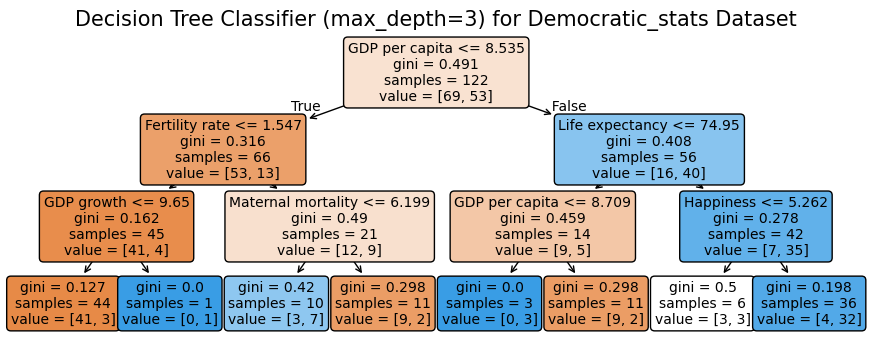

Accuracy (Depth=2): 0.71


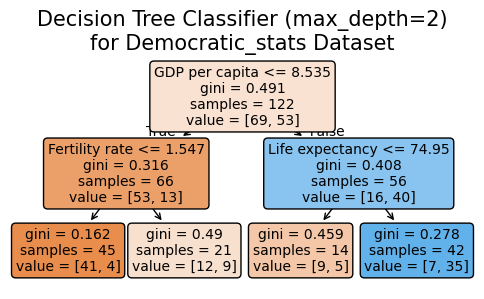

In [30]:
# Fit the regression tree (max_depth=3)
target_variable = 'Net positive migration'
features = Migration_stats.drop(['Country', 'Region', 'Population growth', target_variable], axis=1)
target = Migration_stats[target_variable]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=9)

# Fit the decision tree classifier (max_depth=3)
tree_clf_depth3 = DecisionTreeClassifier(max_depth=3)
tree_clf_depth3.fit(X_train, y_train)

# Predict on the test set (max_depth=3)
y_pred_depth3 = tree_clf_depth3.predict(X_test)
accuracy_depth3 = accuracy_score(y_test, y_pred_depth3)
print(f"Accuracy (Depth=3): {accuracy_depth3:.2f}")

# Plot the tree (max_depth=3)
plt.figure(figsize=(11, 4))
plot_tree(tree_clf_depth3, feature_names=features.columns, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Classifier (max_depth=3) for Democratic_stats Dataset', fontsize=15)
plt.show()

# Fit the decision tree classifier (max_depth=2)
tree_clf_depth2 = DecisionTreeClassifier(max_depth=2)
tree_clf_depth2.fit(X_train, y_train)

# Predict on the test set (max_depth=2)
y_pred_depth2 = tree_clf_depth2.predict(X_test)
accuracy_depth2 = accuracy_score(y_test, y_pred_depth2)
print(f"Accuracy (Depth=2): {accuracy_depth2:.2f}")

# Plot the tree (max_depth=2)
plt.figure(figsize=(6, 3))
plot_tree(tree_clf_depth2, feature_names=features.columns, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Classifier (max_depth=2)\nfor Democratic_stats Dataset', fontsize=15)
plt.show()

Predicting the leave one out cross validation for each of our decision trees

In [31]:
# Initialize LOOCV
loo = LeaveOneOut()
accuracies_depth3 = []
accuracies_depth2 = []

# Perform LOOCV for max_depth=3
for train_index, test_index in loo.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    tree_clf_depth3 = DecisionTreeClassifier(max_depth=3)
    tree_clf_depth3.fit(X_train, y_train)
    y_pred = tree_clf_depth3.predict(X_test)
    accuracies_depth3.append(accuracy_score(y_test, y_pred))

# Average accuracy for max_depth=3
loo_accuracy_depth3 = sum(accuracies_depth3) / len(accuracies_depth3)
print(f"LOO Accuracy (Depth=3): {loo_accuracy_depth3:.2f}")

# Perform LOOCV for max_depth=2
for train_index, test_index in loo.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    tree_clf_depth2 = DecisionTreeClassifier(max_depth=2)
    tree_clf_depth2.fit(X_train, y_train)
    y_pred = tree_clf_depth2.predict(X_test)
    accuracies_depth2.append(accuracy_score(y_test, y_pred))

# Average accuracy for max_depth=2
loo_accuracy_depth2 = sum(accuracies_depth2) / len(accuracies_depth2)
print(f"LOO Accuracy (Depth=2): {loo_accuracy_depth2:.2f}")

LOO Accuracy (Depth=3): 0.71
LOO Accuracy (Depth=2): 0.59


Loading the Democratic database and merging the is democratic binary column into our old database and calling it Democratic_stats

In [32]:
# Load the Democratic dataset from Excel
Democratic = pd.read_excel('ddrevisited_data_v1.xls')

# Replace the country names in the 'ctryname' column
Democratic['ctryname'] = Democratic['ctryname'].replace(replacements)

# Filter for the year 2008 and select relevant columns
Democratic = Democratic[Democratic['year'] == 2008][['ctryname', 'democracy']]

# Convert the 'democracy' column to integer type
Democratic['democracy'] = Democratic['democracy'].astype(int)

# Perform left merge with Migration_stats on 'Country' and 'ctryname'
Democratic_stats = Migration_stats.merge(Democratic, 
                                         left_on='Country', 
                                         right_on='ctryname', 
                                         how='left')

# Drop the duplicate 'ctryname' column if needed
Democratic_stats.drop('ctryname', axis=1, inplace=True)

# Display the resulting DataFrame
Democratic_stats.head()

,Country,Region,Happiness,GDP per capita,GDP growth,Life expectancy,Maternal mortality,Population growth,Fertility rate,Net positive migration,democracy
0,Switzerland,Western Europe,7.587,11.347850,1.7,82.8,1.791759,1.1,0.405465,1,1
1,Iceland,Western Europe,7.561,10.876385,4.4,82.4,1.098612,1.0,0.587787,1,1
2,Denmark,Western Europe,7.527,10.883842,2.3,80.7,1.791759,0.5,0.530628,1,1
3,Norway,Western Europe,7.522,11.216270,2.0,82.3,0.693147,0.9,0.530628,1,1
4,Canada,North America,7.427,10.681665,0.7,81.9,2.484907,1.0,0.470004,1,1


Calculate a Dendogram based on migration and happiness and grouped by region

C:\Users\gavha\AppData\Local\Temp\ipykernel_31680\4191074718.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


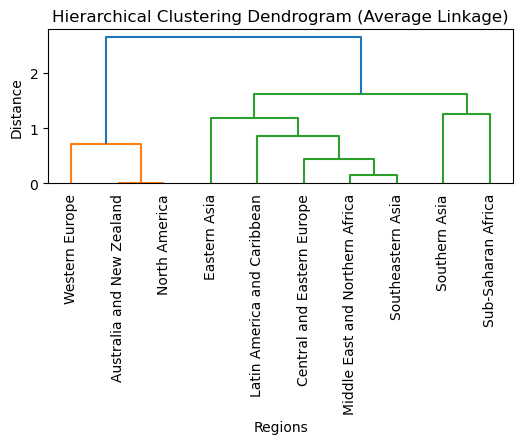

Democratic rate by Region
Australia and New Zealand          1.000
North America                      1.000
Western Europe                     1.000
Latin America and Caribbean        0.955
Eastern Asia                       0.750
Southern Asia                      0.714
Central and Eastern Europe         0.679
Sub-Saharan Africa                 0.350
Southeastern Asia                  0.333
Middle East and Northern Africa    0.105
Name: democracy, dtype: float64


In [33]:
# Group by region and calculate the mean
region_avg = Democratic_stats.groupby('Region').mean().reset_index()

# Function to calculate dendrogram for a given set of variables X
def calculate_region_dendrogram(X):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform hierarchical clustering using average linkage
    Z = linkage(X_scaled, method='average', metric='euclidean')

    # Plot dendrogram
    plt.figure(figsize=(6, 2))
    dendrogram(Z, labels=region_avg['Region'].values, orientation='top', leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram (Average Linkage)')
    plt.xlabel('Regions')
    plt.ylabel('Distance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Calculate dendrogram for 'Net positive migration' and 'Happiness'
X_net_migration = region_avg[['Net positive migration', 'Happiness']]
calculate_region_dendrogram(X_net_migration)

# Display mean democracy scores sorted by region
mean_democracy_by_region = Democratic_stats.groupby('Region')['democracy'].mean().sort_values(ascending=False)
print(f'Democratic rate by {round(mean_democracy_by_region,3)}')

Calulating dendograms for eastern asia and southern asia based on migration and happiness

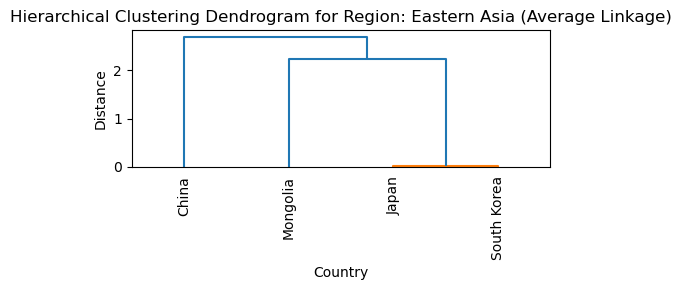

Democracies in Eastern Asia
        Country  democracy
44        Japan          1
45  South Korea          1
95     Mongolia          1


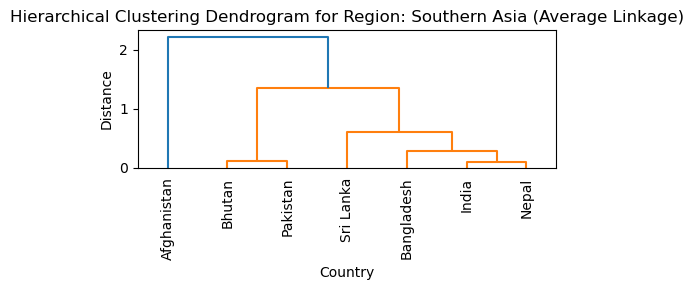

Democracies in Southern Asia
       Country  democracy
74      Bhutan          1
76    Pakistan          1
111      India          1
115      Nepal          1
126  Sri Lanka          1


In [34]:
# Function to calculate dendrogram for a given set of variables X
def calculate_region_dendrogram(X, region_name):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Example: Compute the distance matrix (replace with actual calculation if needed)
    data_dist = np.random.rand(len(X), len(X))

    # Perform hierarchical clustering using average linkage
    Z = linkage(X_scaled, method='average', metric='euclidean')

    # Plot the dendrogram
    plt.figure(figsize=(5,3))
    dendrogram(Z, labels=Democratic_stats[Democratic_stats['Region'] == region_name]['Country'].values, orientation='top', leaf_font_size=10)
    plt.title(f'Hierarchical Clustering Dendrogram for Region: {region_name} (Average Linkage)')
    plt.xlabel('Country')
    plt.ylabel('Distance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage for 'Eastern Asia'
region_name = 'Eastern Asia'
X_net_migration = Democratic_stats[Democratic_stats['Region'] == region_name][['Net positive migration', 'Happiness']]
calculate_region_dendrogram(X_net_migration, region_name)

# Printing democracy scores for 'Eastern Asia'
print(f"Democracies in Eastern Asia\n{Democratic_stats[(Democratic_stats['Region'] == region_name) & (Democratic_stats['democracy'] == 1)][['Country', 'democracy']]}")

# Example usage for 'Southeastern Asia'
region_name = 'Southern Asia'
X_net_migration = Democratic_stats[Democratic_stats['Region'] == region_name][['Net positive migration', 'Happiness']]
calculate_region_dendrogram(X_net_migration, region_name)

# Example printing democracy scores for 'Southern Asia'
print(f"Democracies in Southern Asia\n{Democratic_stats[(Democratic_stats['Region'] == region_name) & (Democratic_stats['democracy'] == 1)][['Country', 'democracy']]}")

Using k means clustering with k=2 to group our data into 2 clusters and plotting this 

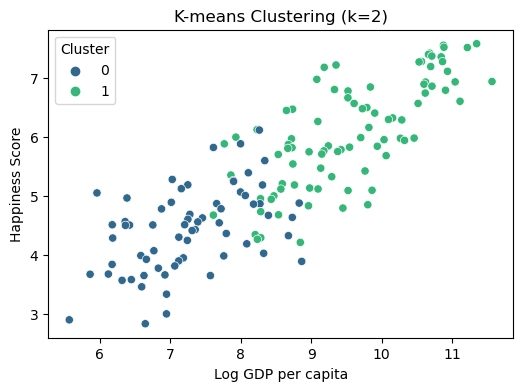

In [35]:
X = Democratic_stats.drop(['Country', 'Region', 'democracy'], axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the K-means model
kmeans = KMeans(n_clusters=2, random_state=9)
kmeans.fit(X_scaled)

# Add the cluster labels to the original DataFrame
Democratic_stats['Cluster'] = 1-kmeans.labels_

# Visualize K-means clustering results
plt.figure(figsize=(6, 4))
sns.scatterplot(data=Democratic_stats, x='GDP per capita', y='Happiness', hue='Cluster', palette='viridis')
plt.title('K-means Clustering (k=2)')
plt.xlabel('Log GDP per capita')
plt.ylabel('Happiness Score')
plt.legend(title='Cluster')
plt.show()

Plotting our democratic binary variable and building accuracy matrixes for comparing our democratic variable to our clusters and the data split by gdp

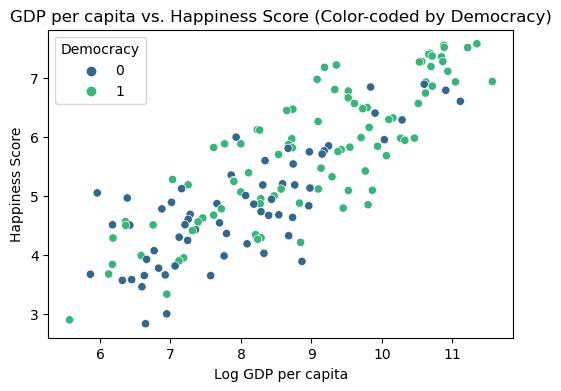

Cluster Counts:
democracy   0   1
Cluster          
0          40  26
1          22  65
Overall Accuracy: 0.686
GDP split_counts:
democracy   0   1
GDP split        
0          35  27
1          27  64
Overall Accuracy: 0.647


In [36]:
# Visualize relationship between GDP per capita, Happiness Score, and Democracy
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=Democratic_stats,
    x='GDP per capita',
    y='Happiness',
    hue='democracy',
    palette='viridis'
)
plt.title('GDP per capita vs. Happiness Score (Color-coded by Democracy)')
plt.xlabel('Log GDP per capita')
plt.ylabel('Happiness Score')
plt.legend(title='Democracy')
plt.show()

# Calculate the percentage of countries with net positive migration in each cluster
cluster_counts = Democratic_stats.groupby(['Cluster', 'democracy']).size().unstack(fill_value=0)
print("Cluster Counts:")
print(cluster_counts)

Accuracy = (cluster_counts.iloc[0, 0] + cluster_counts.iloc[1, 1]) / cluster_counts.values.sum()

print(f"Overall Accuracy: {round(Accuracy, 3)}")

# Split the DataFrame into two halves based on GDP per capita
Democratic_stats['GDP split'] = Democratic_stats['GDP per capita'].apply(lambda x: 1 if x > Democratic_stats['GDP per capita'].quantile((Democratic_stats['democracy']==0).sum()/153) else 0)

# Calculate the percentage of countries with net positive migration in each GDP split
GDP_split_counts = Democratic_stats.groupby(['GDP split', 'democracy']).size().unstack(fill_value=0)
print("GDP split_counts:")
print(GDP_split_counts)

Accuracy = (GDP_split_counts.iloc[0, 0] + GDP_split_counts.iloc[1, 1]) / GDP_split_counts.values.sum()
print(f"Overall Accuracy: {round(Accuracy, 3)}")

# Drop the 'Cluster' column if not needed beyond this point
Democratic_stats = Democratic_stats.drop(columns=['Cluster', 'GDP split'], axis=1)

Using and exploring PCA to reduce our data 

Explained Variance Ratios:
PC1: 0.626
PC2: 0.155
PC3: 0.127
PC4: 0.043
PC5: 0.020
PC6: 0.016
PC7: 0.012


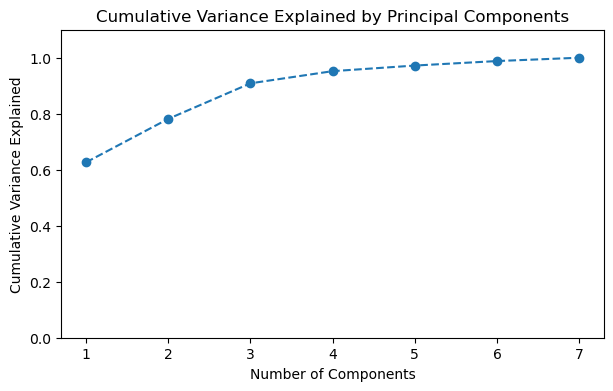

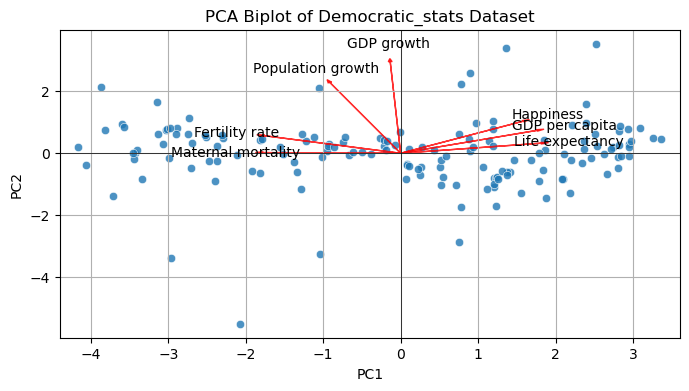

PCA Components (Loadings):
   Happiness  GDP per capita  GDP growth  Life expectancy  Maternal mortality  \
0   0.395160        0.439951   -0.033643         0.453160           -0.444384   
1   0.258515        0.184482    0.739183         0.081205            0.005389   
2  -0.253782       -0.183466    0.672047        -0.045088            0.006648   
3   0.742670        0.086510   -0.011435        -0.301604            0.417790   
4  -0.028391       -0.048434   -0.019920         0.203208            0.696660   
5  -0.379348        0.848827    0.003900        -0.301025            0.192675   
6  -0.127843        0.091721   -0.016931         0.750430            0.324719   

   Population growth  Fertility rate  
0          -0.228239       -0.440722  
1           0.570951        0.141905  
2          -0.644469       -0.181302  
3          -0.362528        0.209492  
4           0.182993       -0.660557  
5          -0.077282        0.043141  
6          -0.188935        0.520262  


In [37]:
# Perform PCA on the data
X = Democratic_stats.drop(['Country', 'Region', 'democracy', 'Net positive migration'], axis=1)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Print explained variance ratios
print("Explained Variance Ratios:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.3f}")

# Plot explained variance ratios
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.ylim(0, 1.1)
plt.grid(False)
plt.show()

# Biplot with arrows for variable loadings
plt.figure(figsize=(8, 4))  # Increase width to stretch data points side to side
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], alpha=0.8)

# Scale factor for arrows
arrow_scale = 4  # Increase the scale factor for better visibility

# Add variable loadings
for i, (pc1, pc2) in enumerate(zip(pca.components_[0, :], pca.components_[1, :])):
    plt.arrow(0, 0, pc1 * arrow_scale, pc2 * arrow_scale, color='r', alpha=0.8, head_width=0.05, head_length=0.1)
    plt.text(pc1 * arrow_scale * 1.2, pc2 * arrow_scale * 1.2, X.columns[i], color='black', ha='center', va='center')

plt.title('PCA Biplot of Democratic_stats Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.gca().set_aspect(0.4, adjustable='datalim')  # Stretch the x-axis
plt.show()

# Access PCA components (loadings)
pca_components = pd.DataFrame(pca.components_, columns=X.columns)
print("PCA Components (Loadings):")
print(pca_components)

Building a neural network to predict the democracy based on the rest of our data

C:\Users\gavha\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Prediction Accuracies: Normal Model
Train Accuracy: 0.83
Test Accuracy: 0.77


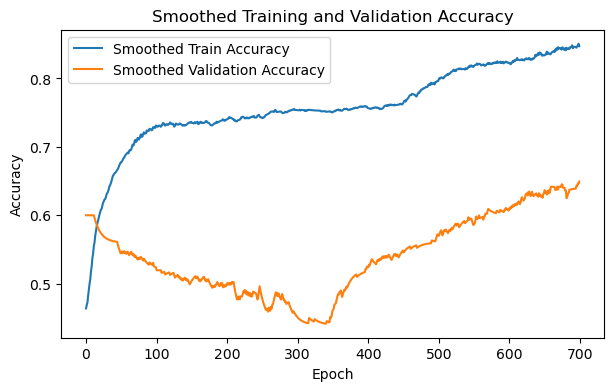

In [38]:
# Define a function to build the Keras model
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
    ])
    
    model.compile(loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
                  optimizer=RMSprop(),
                  metrics=['accuracy'])  # Use accuracy as the metric
    
    return model

# Define independent variables (X) and dependent variable (y)
X = Democratic_stats.drop(['Country', 'Region','democracy'], axis=1)
y = Democratic_stats['democracy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Build the Keras model
model = build_model()

# Train the model
history = model.fit(X_train, y_train, epochs=700, validation_split=0.2, verbose=0)

# Evaluate the model on both train and test sets
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print accuracy scores
print('Prediction Accuracies: Normal Model')
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Function to smooth the data
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the training history
smoothed_train_accuracy = smooth_curve(history.history['accuracy'])
smoothed_val_accuracy = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training history for accuracy
plt.figure(figsize=(7, 4))
plt.plot(smoothed_train_accuracy, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracy, label='Smoothed Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Smoothed Training and Validation Accuracy')
plt.show()

Predicting democracy using our neural network and just our first 4 PCA variables as predictors

Prediction Accuracies: 4 PCA Component Model
Train Accuracy: 0.77
Test Accuracy: 0.74


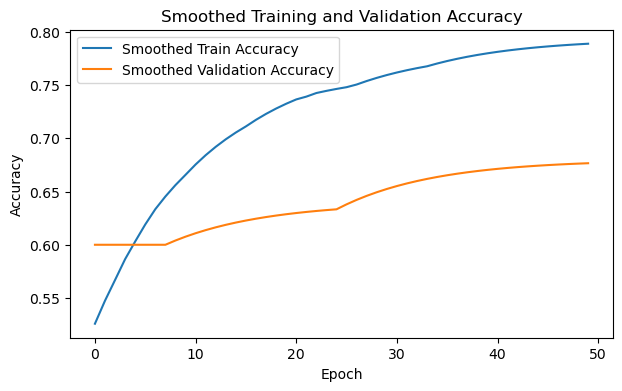

In [39]:
# Define independent variables (X) and dependent variable (y)
X = X_pca[:, [0, 1, 2, 3]]
y = Democratic_stats['democracy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Build the Keras model
model = build_model()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)

# Evaluate the model on both train and test sets
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print accuracy scores
print('Prediction Accuracies: 4 PCA Component Model')
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Function to smooth the data
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the training history
smoothed_train_accuracy = smooth_curve(history.history['accuracy'])
smoothed_val_accuracy = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training history for accuracy
plt.figure(figsize=(7, 4))
plt.plot(smoothed_train_accuracy, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracy, label='Smoothed Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Smoothed Training and Validation Accuracy')
plt.show()